In [1]:
import os, sys, numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from bandit_agents import IGPUCB

from environments import NoiseEnv

Current path: /Users/marcomussi/git/HetGaussianProcesses


/var/folders/4z/mvrgdd8923g26xd4nhj_0gdh0000gn/T/ipykernel_57779/2964140565.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def run_simulations(agent, env, horizon, n_runs): 
    
    pseudo_regret_all = np.zeros((n_runs, horizon))
    regret_all = np.zeros((n_runs, horizon))
    horizon_plt = np.linspace(1, horizon, horizon, dtype=int)

    for run_i in range(n_runs):
        
        agent.reset()
        env.reset(seed=run_i)
        
        actions = np.zeros((horizon, agent.action_dim))
        actions_idx = np.zeros(horizon, dtype=int)
        rewards = np.zeros(horizon)
        
        for t in tqdm(range(horizon)):
            
            actions[t, :] = agent.pull()
            actions_idx[t] = np.where((env.actions == actions[t, :]).all(axis=1))[0][0]
            rewards[t] = env.step(actions[t, :])
            agent.update(rewards[t])

        regret_all[run_i, :] = np.cumsum(np.max(env.values) - rewards)
        pseudo_regret_all[run_i, :] = np.cumsum(np.max(env.values) - env.values[actions_idx])
    
    plt.figure()
    plt.plot(horizon_plt, np.mean(regret_all, axis=0), label="Average Cumulative Regret")
    plt.fill_between(horizon_plt, np.mean(regret_all, axis=0) - np.std(regret_all, axis=0), np.mean(regret_all, axis=0) + np.std(regret_all, axis=0), alpha=0.3)
    plt.plot(horizon_plt, np.mean(pseudo_regret_all, axis=0), label="Average Cumulative Pseudo-Regret")
    plt.fill_between(horizon_plt, np.mean(pseudo_regret_all, axis=0) - np.std(pseudo_regret_all, axis=0), np.mean(pseudo_regret_all, axis=0) + np.std(pseudo_regret_all, axis=0), alpha=0.3)
    plt.legend()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

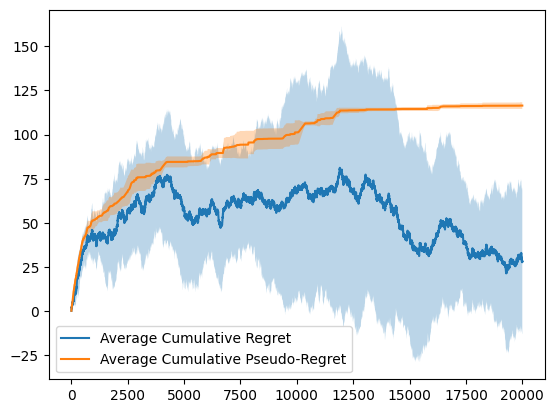

In [3]:
horizon = 20000
kernel_L = 1000
sigma_sq = 0.25
n_actions = 5
n_runs = 3
B = 1
delta = 1 / horizon

actions = np.linspace(0, 1, n_actions).reshape(n_actions, 1)
values = np.array([0.2, 0.3, 0.5, 0.55, 0.4])

agent = IGPUCB(n_actions, 1, actions, kernel_L, sigma_sq, B, delta, het=True)
env = NoiseEnv(actions, values, sigma_sq, bernoulli=False)
run_simulations(agent, env, horizon, n_runs)